## Análise estatística do uso do sistema Bike Sampa

#### Este caderno responde às seguintes questões:

- Quantas viagens ocorreram através dos anos?
- Qual é a distância média percorrida pelos usuários?
- Quanto tempo duram as viagens?
- Qual é a idade média dos usuários?
- Qual é a velocidade média de homens e mulheres?

Os gráficos apresentam os histogramas de cada análise. As linhas verticais vermelhas e azuis representam a mediana da distribuição.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.dates as mdate
from shapely.geometry import Point
import geopandas as gpd
import folium
import math
import datetime as dt
import glob
from ipywidgets import interact_manual, widgets
from scipy.interpolate import CubicSpline
import seaborn as sbn
import warnings

import bikescience.charts as ch
import tembici.load_trips as load
import tembici.stations as tst
import bikescience.distributions as dist
from IPython.core.display import display, HTML

pd.set_option('display.float_format', lambda x: '%.1f' % x)
# global settings for the charts
plt.rcParams['font.family'] = 'FreeSerif'
#plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 18
warnings.simplefilter('ignore')

##loading data
trips = load.load_trips_files('../../../tembici/trips_*.csv')

stations = pd.read_csv('../../../tembici/Estações_Tembici_fev2019.csv')
stations = stations[stations.project == 'BikeSampa']
stations = tst.stations_geodf(stations)
stations.reset_index(inplace=True)

stations_distances = pd.read_csv('../../data/sao-paulo/bike-stations/stations_distances.csv')
stations_distances.columns = ['distance', 'index_start', 'index_end']

station_ids = stations[['name', 'index']]
station_ids.columns = ['start_station_name', 'index']
merge = trips.merge(station_ids, on='start_station_name')
station_ids.columns = ['end_station_name', 'index']
merge = merge.merge(station_ids, on='end_station_name', suffixes=('_start', '_end'))
merge = merge.merge(stations_distances, on=['index_start', 'index_end'])
merge['speed'] = merge['distance']/merge['tripduration']*3600

#subsets for analysis
#age
tage = trips[~trips["birth year"].isnull()]
tage = tage["starttime"].dt.year - tage["birth year"]
tage = tage[(tage > 0) & (tage < 100)]
#duration
duration = trips[trips['tripduration'] < 3000]
duration = duration[['tripduration']]
#gender
male = trips[trips['gender'] == 'Masc']
female = trips[trips['gender'] == 'Fem']
unknown = trips[trips['gender'] == 'Null']
#distance
distance = merge[(merge.distance<10) & (merge.distance>0)]
distance = distance[['distance']]
#gender vs speed
gender = merge
gender = gender[gender.distance < 50]
gender.reset_index(inplace=True)
gender = gender[['gender','distance','tripduration','speed']]

women_speed = gender[(gender.gender == 'Fem') & (gender.speed> 0) & (gender.speed < 30)].speed
men_speed   = gender[(gender.gender == 'Masc') & (gender.speed> 0) & (gender.speed < 30)].speed

#time series analysis
trip_time_series = trips[['starttime', 'gender']]
trip_time_series = \
        trip_time_series[(trip_time_series.starttime < pd.Timestamp('2020-01-01 00:00:0000'))]
trip_time_series.set_index(pd.DatetimeIndex(trip_time_series['starttime']), inplace=True)
#month average
trips_day_average = trip_time_series['starttime'].groupby(pd.Grouper(freq='D')).count()
trips_per_month = trips_day_average.groupby(pd.Grouper(freq='MS')).agg(mean='mean',std='std')
#women bike usage percentage
women_trips = trip_time_series[(trip_time_series.gender == 'Fem')]
men_trips = trip_time_series[(trip_time_series.gender == 'Masc')]

women_trips_day_count = women_trips['starttime'].groupby(pd.Grouper(freq='D')).count()
men_trips_day_count = men_trips['starttime'].groupby(pd.Grouper(freq='D')).count()

women_trips_per_month = women_trips_day_count.groupby(pd.Grouper(freq='MS')).agg(sum='sum')
men_trips_per_month = men_trips_day_count.groupby(pd.Grouper(freq='MS')).agg(sum='sum')

women_percentage_per_month = women_trips_per_month.copy()
men_percentage_per_month = men_trips_per_month.copy()

women_percentage_per_month['percentage'] = \
    women_percentage_per_month['sum']/(women_percentage_per_month['sum']+men_percentage_per_month['sum'])*100
#filling the missing month 2019-03-01 using the average of the previous and following months
trips_per_month.at['2019-03-01','mean'] = (trips_per_month.loc['2019-02-01','mean'] + trips_per_month.loc['2019-04-01','mean'])/2
trips_per_month.at['2019-03-01','std'] = (trips_per_month.loc['2019-02-01','std'] + trips_per_month.loc['2019-04-01','std'])/2

women_percentage_per_month.at['2019-03-01','sum'] = (women_percentage_per_month.loc['2019-02-01','sum'] + women_percentage_per_month.loc['2019-04-01','sum'])/2
women_percentage_per_month.at['2019-03-01','percentage'] = (women_percentage_per_month.loc['2019-02-01','percentage'] + women_percentage_per_month.loc['2019-04-01','percentage'])/2

#speeders
t = merge[~merge["birth year"].isnull()]
t["birth year"] = t["birth year"].astype(int)
t["age"] = 2018 - t["birth year"]
speeders = t[t.speed >25].age
normal  = t.age

#statistics functions
def idade():
    plt.figure(figsize=(14,8))
    loc = tkr.MultipleLocator(base=10)
    ax_age = plt.axes()
    ax_age.set_axisbelow(True)
    plt.grid(linestyle='--')
    ax_age.xaxis.grid(False)
    formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
    ax_age.yaxis.set_major_formatter(formatter)
    ax_age.xaxis.set_major_locator(loc)
    plt.hist(bins=20,x=tage)
    plt.axvline(x=tage.median(),color='red')
    plt.title('Idade')
    plt.xlabel('Anos')
    plt.ylabel('Viagens (em milhares)')
    plt.show()

def duracao():
    plt.figure(figsize=(14,8))
    loc = tkr.MultipleLocator(base=5)

    ax_duration = plt.axes()
    ax_duration.set_axisbelow(True)
    plt.grid(linestyle='--')
    ax_duration.xaxis.grid(False)
    formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
    ax_duration.yaxis.set_major_formatter(formatter)
    ax_duration.xaxis.set_major_locator(loc)
    plt.hist(bins=100,x=duration['tripduration']/60)
    plt.title('Duração')
    plt.xlabel('Minutos')
    plt.ylabel('Viagens (em milhares)')
    #fig_duration = plt.gcf()
    plt.axvline(x=9.5,color='red')
    plt.show()
    
def genero():
    display(HTML('<div class=\"custom\"><h3>Gênero</h3>'))
    display(HTML('<div class=\"custom\"><h3>Homens: %s (%s)</h3>'%("{0:.2%}".format(len(male) / len(trips)),len(male))))
    display(HTML('<div class=\"custom\"><h3>Mulheres: %s (%s)</h3>'%("{0:.2%}".format(len(female) / len(trips)),len(female))))
    display(HTML('<div class=\"custom\"><h3>Desconhecido: %s (%s)</h3>'%("{0:.2%}".format(len(unknown) / len(trips)),len(unknown))))

def velocidade_por_genero():
    plt.figure(figsize=(14,8))
    loc = tkr.MultipleLocator(base=1)

    bins = np.linspace(0, 30, 100)
    ax_gender = plt.axes()
    ax_gender.xaxis.grid(False)
    ax_gender.yaxis.grid(False)
    ax_gender.xaxis.set_major_locator(loc)
    plt.hist(men_speed, bins, alpha=0.5, label='homens', density=True, color='blue')
    plt.hist(women_speed, bins, alpha=0.5, label='mulheres', density=True, color='red')
    plt.legend(loc='upper right')
    plt.title('Velocidade')
    plt.axvline(x=women_speed.mean(),color='red')
    plt.axvline(x=men_speed.mean(),color='blue')
    plt.xlabel('Velocidade (km/h)')
    plt.ylabel('Viagens (densidade)')
    plt.show()

def apressados():
    plt.figure(figsize=(14,8))
    loc = tkr.MultipleLocator(base=5)

    bins = np.linspace(10, 70, 30)
    plt.hist(speeders, bins, alpha=0.5, label='apressados', density=True, color='blue')
    plt.hist(normal, bins, alpha=0.5, label='normais', density=True, color='red')
    #plt.xaxis.set_major_locator(loc)
    plt.axvline(x=speeders.mean(),color='blue')
    plt.axvline(x=normal.mean(),color='red')
    plt.xlabel('Idade')
    plt.ylabel('Frequência (%)')
    plt.legend(loc='upper right')
    plt.title('Apressados: Viagens com velocidade média acima de 25km/h')
    plt.show()
    
def distancia():
    plt.figure(figsize=(14,8))
    loc = tkr.MultipleLocator(base=1)

    ax_distance = plt.axes()
    ax_distance.set_axisbelow(True)
    plt.grid(linestyle='--')
    ax_distance.xaxis.grid(False)
    formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
    ax_distance.yaxis.set_major_formatter(formatter)
    ax_distance.xaxis.set_major_locator(loc)
    plt.hist(bins=16,x=distance['distance'])
    plt.title('Distância')
    plt.xlabel('Kilômetros')
    plt.ylabel('Viagens (em milhares)')
    plt.axvline(x=distance['distance'].median(),color='red')
    #fig_distance = plt.gcf()
    plt.show()

def serie_temporal():
    dateFmt = mdate.DateFormatter('%b/%y')

    ax_day_avg_gender = plt.axes()
    ax_day_avg_gender.set_axisbelow(True)
    ax_day_avg_gender.xaxis.grid(False)
    ax_day_avg_gender.yaxis.grid(False)
    ax_day_avg_gender.plot(trips_per_month['mean'], label='viagens diárias', linewidth=3)
    ax_day_avg_gender.figure.set_size_inches(18,10)
    ax_day_avg_gender.xaxis.set_major_formatter(dateFmt)
    ax_day_avg_gender.xaxis.set_minor_locator(mdate.MonthLocator())

    plt.ylabel('viagens/dia')
    plt.xticks(rotation=45)
    plt.yticks(np.arange(0,10001,step=1000))
    plt.fill_between(trips_per_month.index,trips_per_month['mean']-trips_per_month['std'],
                     trips_per_month['mean']+trips_per_month['std'],color='lightgray',label='desvio padrão')
    plt.legend(loc='center left')
    plt.title('Viagens por mês e gênero: média de uso diária e desvio padrão de Jan/2018 até o mês com dados mais recentes')

    ax_perc_women = ax_day_avg_gender.twinx()
    ax_perc_women.plot(women_percentage_per_month.index,women_percentage_per_month['percentage'],label='viagens de mulheres (%)',color='red')
    ax_perc_women.set_ylabel('viagens/dia (%)', color='red')
    ax_perc_women.yaxis.grid(False)
    ax_perc_women.xaxis.set_major_formatter(dateFmt)
    ax_perc_women.set_yticks(np.arange(0,30.1,step=5))
    ax_perc_women.legend(loc='upper left')
    ax_perc_women.tick_params('y',colors='red')

    plt.savefig('charts/Trips-Evolution.pdf', format='pdf', dpi=200)
    plt.draw()

# showing summary of the BSS data size
display(HTML('<div class=\"custom\"><h3>%s viagens até a data mais atual dos dados</h3>'%(len(trips))))
display(HTML('<div class=\"custom\"><h3>%s estações em São Paulo</h3>'%(len(stations))))

def estatisticas():
    idade()
    duracao()
    genero()
    velocidade_por_genero()
    distancia()
    serie_temporal()
    apressados()



In [17]:
trips.head(30)

tripduration                   start_station_name           starttime  \
0            570          109 - Praça Oswaldo Varella 2019-11-01 00:01:19   
1           3159              12 - Largo de Batata II 2019-11-01 00:01:30   
2            777               322 - Metrô Eucaliptos 2019-11-01 00:02:35   
3            734                    69 - Oscar Freire 2019-11-01 00:03:06   
4            529             307 - Metrô Vila Mariana 2019-11-01 00:03:19   
5           3447                    69 - Oscar Freire 2019-11-01 00:03:34   
6           1367                   144 - Rua Iguatemi 2019-11-01 00:03:44   
7            213            148 - R. Maria Figueiredo 2019-11-01 00:06:26   
8           1061                      117 - Cubo Itaú 2019-11-01 00:06:38   
9            166                95 - Metrô Brigadeiro 2019-11-01 00:08:00   
10           652                      194 - jaguaribe 2019-11-01 00:08:42   
11           562                   333 -R. Flórida 53 2019-11-01 00:09:10   
12          3509                118 - Rua Júlio Diniz 2019-11-01 00:10:52   
13           959                      232 - Sumidouro 2019-11-01 00:11:30   
14           955                 14 - Casa Brasileira 2019-11-01 00:11:56   
15           382      116 - Praça Dr. Francisco Patti 2019-11-01 00:12:17   
16           233  17 - Rua José Gonçalves de Oliveira 2019-11-01 00:13:51   
17          1133        27 - Rua Min. Jesuíno Cardoso 2019-11-01 00:15:32   
18          4032                      123 - Rua Egito 2019-11-01 00:15:55   
19           469                  75 - Viaduto Tutóia 2019-11-01 00:16:02   
20          2611                   209 - Haddock Lobo 2019-11-01 00:16:19   
21           939             240 - Praça Panamericana 2019-11-01 00:17:05   
22          1944                157 - Theatro Ribalta 2019-11-01 00:18:58   
23          1259                95 - Metrô Brigadeiro 2019-11-01 00:20:28   
24           584                         49 - Tapinás 2019-11-01 00:20:33   
25           725                     214 - João Moura 2019-11-01 00:21:35   
26          1622        44 - Pq. Ibirapuera Portão 09 2019-11-01 00:21:55   
27           502             335 - R. Ribeiro do Vale 2019-11-01 00:22:37   
28           752                118 - Rua Júlio Diniz 2019-11-01 00:22:58   
29           410                95 - Metrô Brigadeiro 2019-11-01 00:24:44   

                    end_station_name            stoptime usertype  birth year  \
0                     337 - Castilho 2019-11-01 00:10:49      NaN         nan   
1            12 - Largo de Batata II 2019-11-01 00:54:09      NaN         nan   
2             322 - Metrô Eucaliptos 2019-11-01 00:15:32      NaN         nan   
3                 209 - Haddock Lobo 2019-11-01 00:15:20      NaN         nan   
4              301 - R. França Pinto 2019-11-01 00:12:08      NaN         nan   
5                1 - Largo da Batata 2019-11-01 01:01:01      NaN         nan   
6                 110 - Flórida 1670 2019-11-01 00:26:31      NaN         nan   
7                75 - Viaduto Tutóia 2019-11-01 00:09:59      NaN         nan   
8                      321 - Gaivota 2019-11-01 00:24:19      NaN         nan   
9                   76 - 8° Batalhão 2019-11-01 00:10:46      NaN         nan   
10             167 - Praca Roosevelt 2019-11-01 00:19:34      NaN         nan   
11                    337 - Castilho 2019-11-01 00:18:32      NaN         nan   
12    141 - Praça Luis Carlos Paraná 2019-11-01 01:09:21      NaN         nan   
13           143- Rua João Cachoeira 2019-11-01 00:27:29      NaN         nan   
14              14 - Casa Brasileira 2019-11-01 00:27:51      NaN         nan   
15               332 - Rua Nova York 2019-11-01 00:18:39      NaN         nan   
16                      49 - Tapinás 2019-11-01 00:17:44      NaN         nan   
17                    337 - Castilho 2019-11-01 00:34:25      NaN         nan   
18      19 - Av. Dr. Cardoso de Melo 2019-11-01 01:23:07      NaN         nan

Execute o botão com duas setas (>>) no menu acima para carregar o código e os arquivos da BikeScience.
Os gráficos e os comandos para gerar as análises estatísticas irão aparecer quando tudo estiver pronto.

In [2]:
#estatisticas()

### Idade

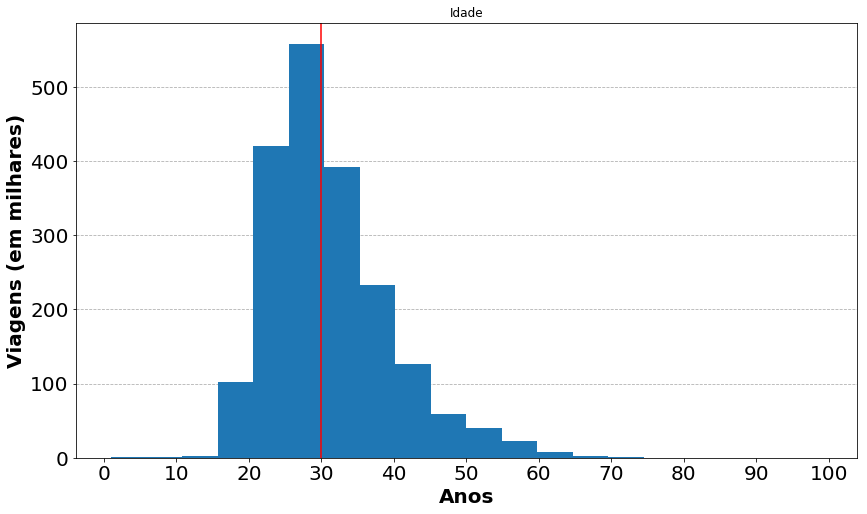

In [2]:
idade()

### Duração

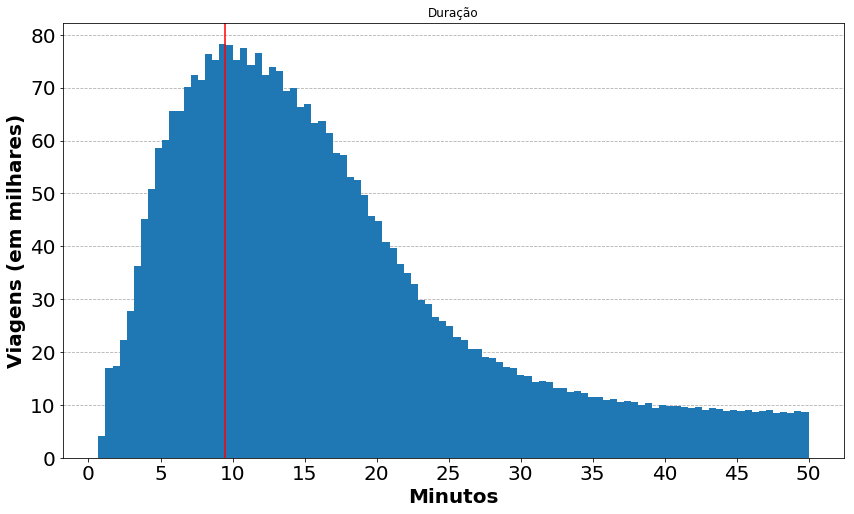

In [4]:
duracao()

In [5]:
genero()

### Velocidade x Gênero

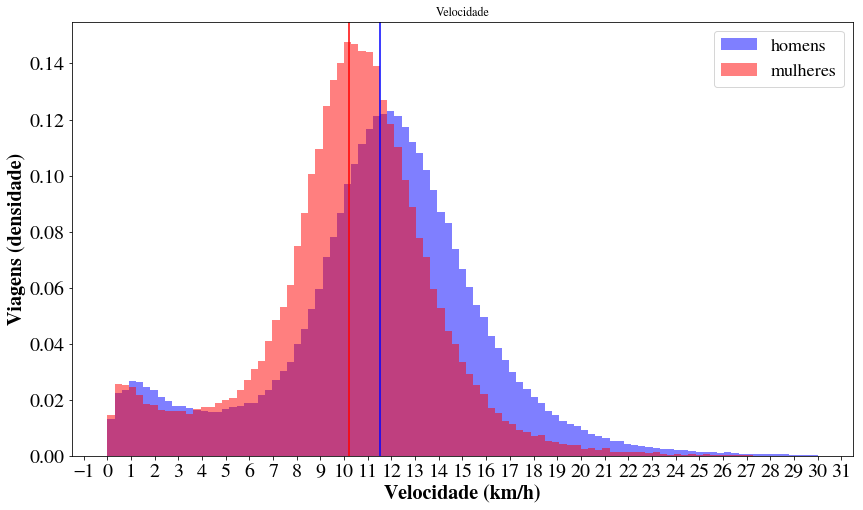

In [6]:
velocidade_por_genero()

### Distância

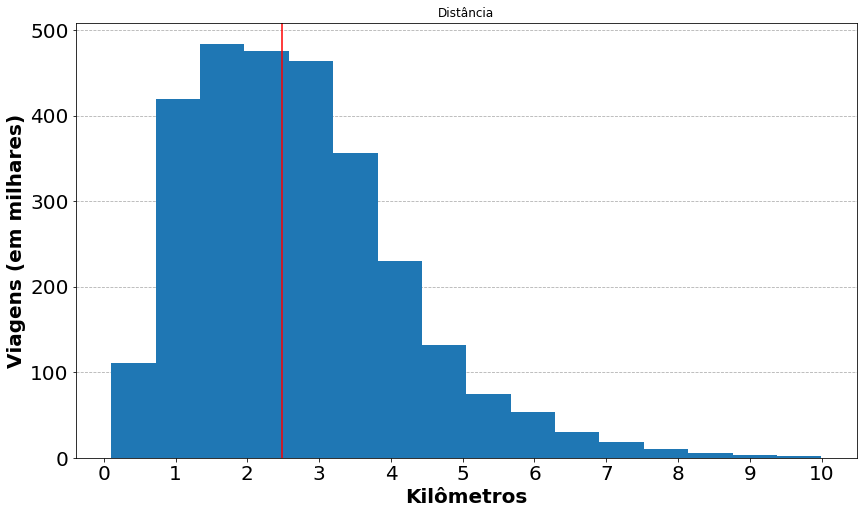

In [6]:
distancia()

### Série temporal

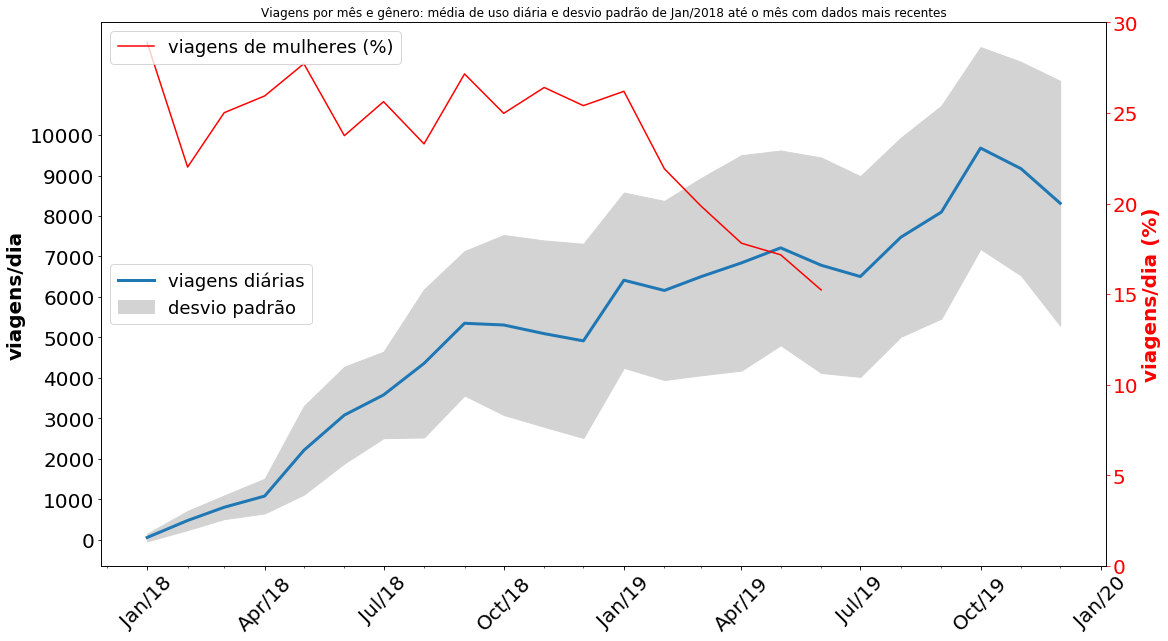

In [11]:
serie_temporal()

### Ciclistas apressados - viagens com velocidade média acima de 25km/h

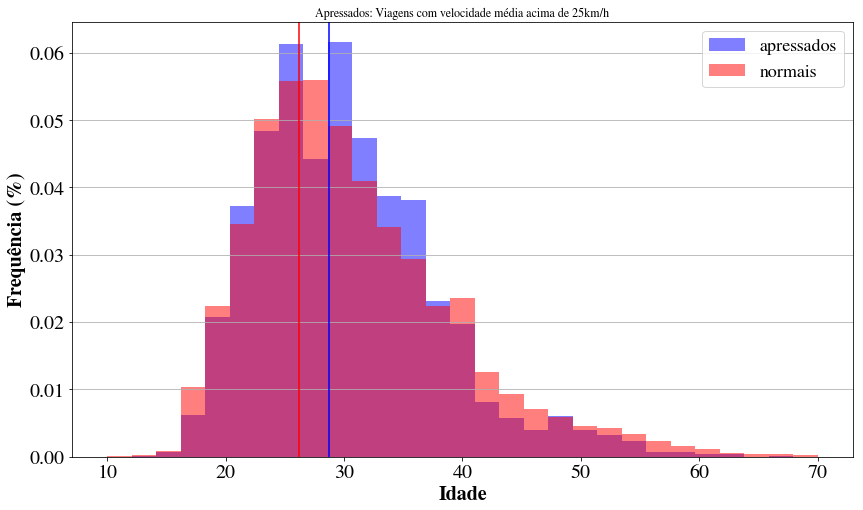

In [9]:
apressados()

### Padrão diário de viagens por estação e por ponto da viagem (partida ou chegada)
- Selecione a estação desejada e o ponto da viagem

In [10]:
def trip_daily_pattern(station, trip_point):
    print('Calculando...')
    station_id = stations[stations['name'] == station].index[0]
    day_counts = merge[merge['index_' + trip_point] == station_id] \
          [['hour', 'weekend', 'per_day']].drop_duplicates() \
          .groupby(['hour', 'weekend'], as_index=False).agg({'per_day': 'count'})
    trip_counts = merge[merge['index_' + trip_point] == station_id] \
                .groupby(['hour', 'weekend'], as_index=False).agg({'tripduration': 'count'})
    counts = day_counts.merge(trip_counts, on=['hour', 'weekend'])
    counts.rename(columns={'per_day': 'day_count', 'tripduration': 'trip_count'}, inplace=True)
    counts['daily_mean'] = counts['trip_count'] / counts['day_count']
    
    plt.figure(figsize=(20, 8))
    width=0.5
        
    for t in [False, True]:
        filtered = counts[counts['weekend'] == t]
        y = filtered['daily_mean']
        x = filtered['hour']
        if len(x) > 0:
            plt.bar(x-width/2 if t else x+width/4, y, width=width, label='fins de semana' if t else 'dais úteis')
        if len(x) >= 2:  # mininum for spline generation
            spline = CubicSpline(x, y)
            x_vals = np.linspace(x.min(), x.max(), 500, dtype=np.float64)
            y_smooth = spline(x_vals)
            plt.plot(x_vals, y_smooth)
        
    plt.xlabel('Hora')
    plt.ylabel('Média diária')
    plt.legend()
    print('Feito.')
    plt.show()
    
im = interact_manual(
    trip_daily_pattern,
    station=widgets.Dropdown(options=stations['name'].sort_values(), value='1 - Largo da Batata'),
    trip_point=widgets.RadioButtons(options=[('origem','start'), ('destino','end')])
)
im.widget.children[0].description = 'Estação'
im.widget.children[1].description = 'Ponto da viagem'
im.widget.children[2].description = 'Mostrar gráfico' 

interactive(children=(Dropdown(description='station', options=('1 - Largo da Batata', '10 - Rua Campo Verde', …

### Estações com maior quantidade de viagens (partida e chegada)

In [11]:
def top_stations(top,trip_point):
    print('Calculando...')
    if trip_point == 'start':
        trips_by_day = trips.groupby(['start_station_name'], as_index=False).agg({'tripduration': 'count'})
        trips_by_day.columns = ['start_station_name', 'trip count']
        trips_by_day.set_index('start_station_name',inplace=True)
    else:
        trips_by_day = trips.groupby(['end_station_name'], as_index=False).agg({'tripduration': 'count'})
        trips_by_day.columns = ['end_station_name', 'trip count']
        trips_by_day.set_index('end_station_name',inplace=True)

    trips_by_day.columns = ['# viagens']
    trips_by_day.index.name='estação'
    
    display(trips_by_day.sort_values('# viagens', ascending=False).head(top))

im = interact_manual(
    top_stations,
    top=widgets.Dropdown(options=[('5', 5), ('10', 10), ('15', 15), ('20', 20), ('25', 25), ('30', 30)], value=10),
    trip_point=widgets.RadioButtons(options=[('origem','start'), ('destino','end')])
)
im.widget.children[0].description = '# estações' 
im.widget.children[1].description = 'Situação' 
im.widget.children[2].description = 'Mostrar lista' 

interactive(children=(Dropdown(description='top', index=1, options=(('5', 5), ('10', 10), ('15', 15), ('20', 2…

### Média de viagens em dias úteis

In [ ]:
workday_trips = trips[(trips['weekend']==False) & (trips['holiday']==False)]
total_workdays = workday_trips.per_day.unique()
workday_trips_avg = len(workday_trips)/len(total_workdays)
print(workday_trips_avg)